In [202]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package stopwords to /home/alexna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('train_ml.csv')
df

,bank,feeds,grades,date
0,ubrr,"Много лет являюсь клиентом этого банка, но пос...",1.0,16.02.2017 16:10
1,fk_otkritie,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",2.0,13.12.2016 1:05
2,alfabank,Здравствуйте!Ранее уже оставлял отзыв о вашем ...,NaN,28.06.2019 13:54
3,vtb,Обращаюсь к Вам с жалобой на незаконное списан...,NaN,15.07.2020 14:54
4,promsvyazbank,"Имею потребительский кредит, взятый в Связь-ба...",2.0,04.08.2020 6:38
...,...,...,...,...
74995,trust,Три года длится эпопея с закрытием кредитной к...,1.0,26.10.2016 11:03
74996,fk_otkritie,"Являлся клиентом Бинбанка, пока после слияния ...",2.0,01.02.2020 21:07
74997,sberbank,8 мая 2016 г. мною вносились деньги на банковс...,1.0,14.06.2016 16:03
74998,uralsib,Здравствуйте! Сегодня 21.04.2020 захожу в моби...,3.0,21.04.2020 8:24


Сразу видим, что в столбце с целевой переменной (grades) есть пропуски. В этом ноутбуке будем обучаться на отзывах, для которых есть информация о значении таргета. Но это не единственный подход. Подумайте, что ещё можно сделать

Посмотрим, есть ли пропуски в признаках

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bank    75000 non-null  object 
 1   feeds   75000 non-null  object 
 2   grades  51476 non-null  float64
 3   date    75000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.3+ MB


Сразу преобразуем столбец с меткой времени к соответствующему формату. И удалим строчки с пропусками в таргете

In [5]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M')
df = df.dropna()
df = df.astype({'grades': 'int32'})
df

,bank,feeds,grades,date
0,ubrr,"Много лет являюсь клиентом этого банка, но пос...",1,2017-02-16 16:10:00
1,fk_otkritie,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",2,2016-12-13 01:05:00
4,promsvyazbank,"Имею потребительский кредит, взятый в Связь-ба...",2,2020-08-04 06:38:00
7,homecreditbank,Хочу выразить глубокую благодарность всем сотр...,5,2015-04-19 20:11:00
8,vtb,"6 марта 2019г. В 10:33 при проходе в метро ""Ку...",2,2019-03-28 18:36:00
...,...,...,...,...
74995,trust,Три года длится эпопея с закрытием кредитной к...,1,2016-10-26 11:03:00
74996,fk_otkritie,"Являлся клиентом Бинбанка, пока после слияния ...",2,2020-02-01 21:07:00
74997,sberbank,8 мая 2016 г. мною вносились деньги на банковс...,1,2016-06-14 16:03:00
74998,uralsib,Здравствуйте! Сегодня 21.04.2020 захожу в моби...,3,2020-04-21 08:24:00


In [152]:
df.describe(include='all')

/tmp/ipykernel_609514/1192053151.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,bank,feeds,grades,date,sym_len,word_len,lemmas
count,51476,51476,51476.000000,51476,51476.000000,51476.000000,51476
unique,69,51474,NaN,50942,NaN,NaN,51471
top,sberbank,Не дают погасить задолженность по кредиту.В 20...,NaN,2020-11-02 20:51:00,NaN,NaN,уважаемый клиент кредитоваться банк обязательн...
freq,8355,2,NaN,3,NaN,NaN,2
first,NaN,NaN,NaN,2005-03-28 12:53:00,NaN,NaN,NaN
last,NaN,NaN,NaN,2021-03-26 18:41:00,NaN,NaN,NaN
mean,NaN,NaN,2.395097,NaN,1228.038426,184.688612,NaN
std,NaN,NaN,1.741879,NaN,1016.994525,154.597158,NaN
min,NaN,NaN,1.000000,NaN,24.000000,3.000000,NaN
25%,NaN,NaN,1.000000,NaN,556.000000,82.000000,NaN


Посмотрим на распределение числа отзывов по банкам

In [6]:
feeds_by_bank_count = df.bank.value_counts()
feeds_by_bank_count

sberbank        8355
vtb             5255
tcs             4503
sovcombank      2600
fk_otkritie     2599
                ... 
sdm-bank          33
intesa            31
primsotsbank      31
rncb              30
rnbank            26
Name: bank, Length: 69, dtype: int64

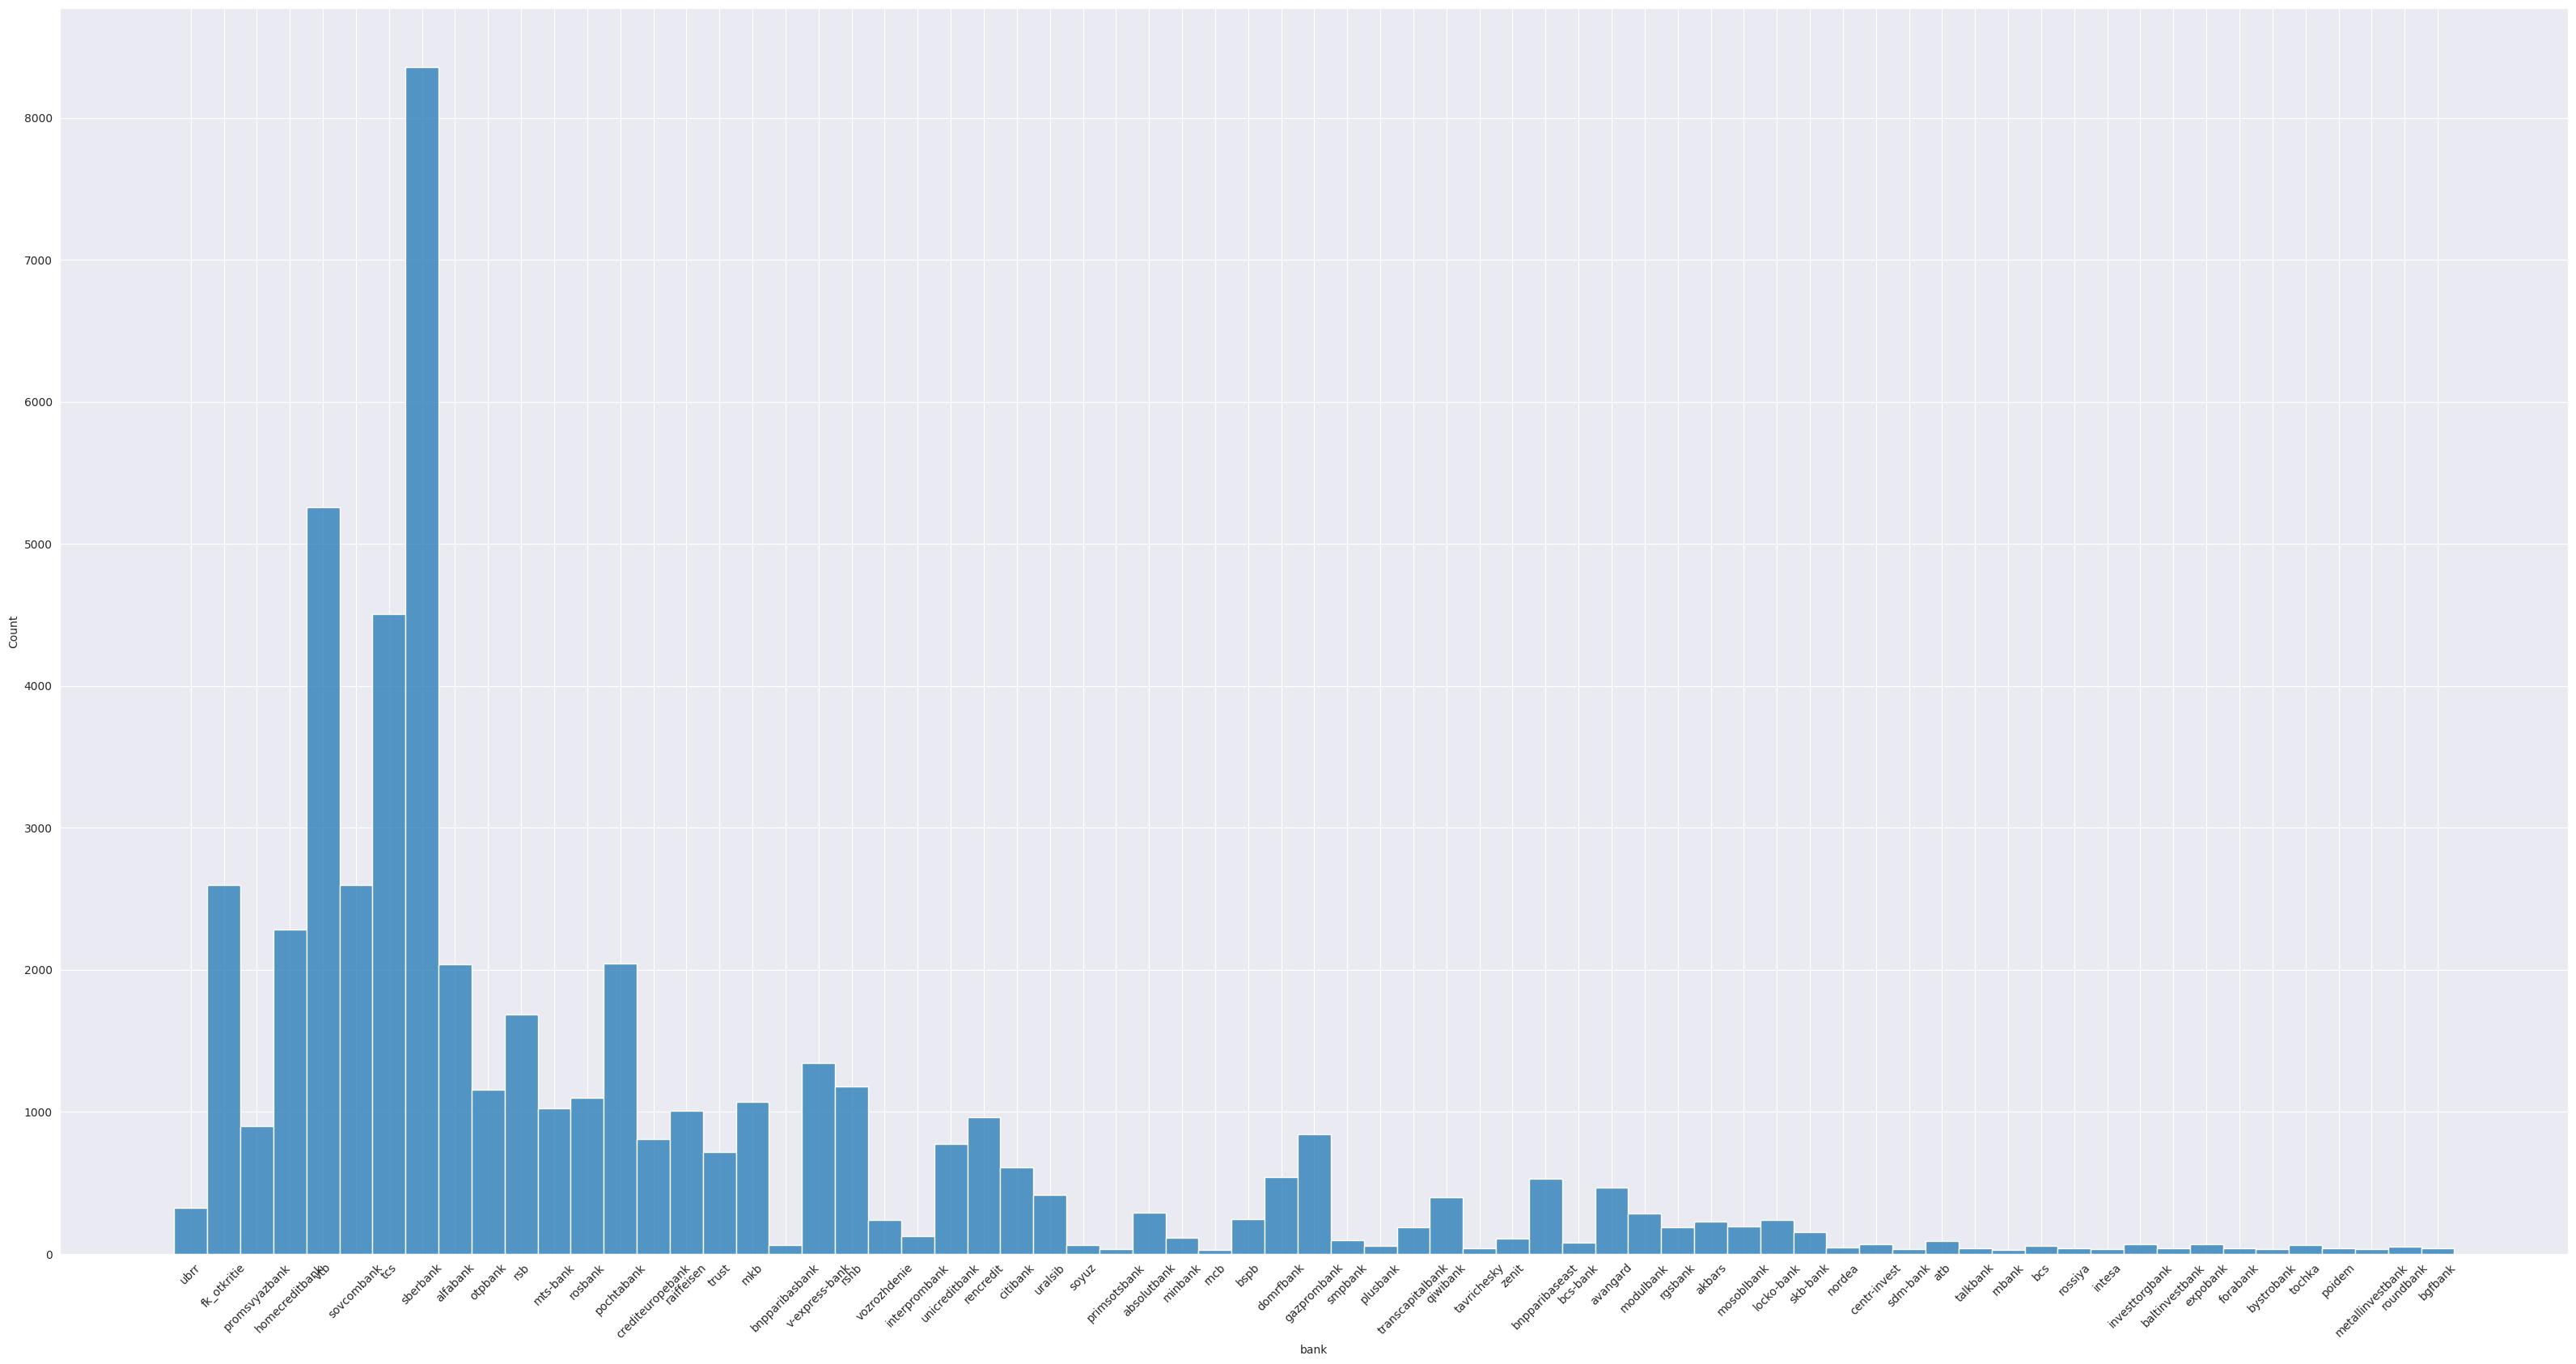

In [9]:
plt.figure(figsize=(40,20))
sns.histplot(data=df.sort_values(by='bank'), x=df.bank, )
plt.xticks(rotation=45)
plt.show()

Глянем на распределение клиентских оценок

In [14]:
df['grades'].value_counts().sort_index()

1    27739
2     5634
3     2356
4     1520
5    14227
Name: grades, dtype: int64

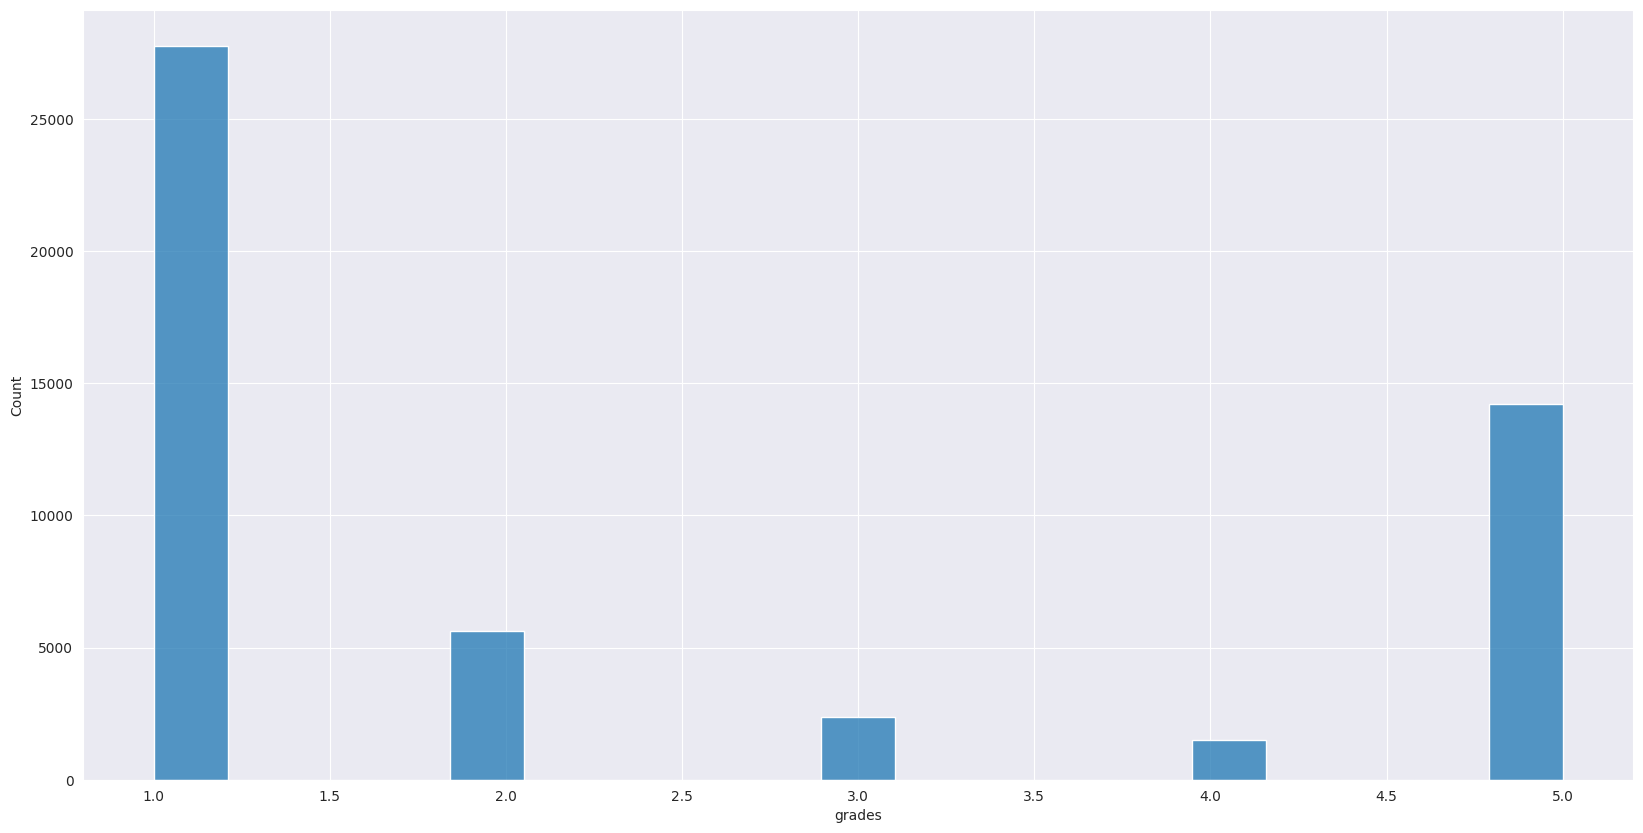

In [15]:
plt.figure(figsize=(20, 10))
sns.histplot(data=df, x=df.grades, )
plt.show()

Также нас интересуют длины отзывов

In [16]:
df['sym_len'] = df['feeds'].apply(len)
df['word_len'] = df['feeds'].apply(lambda x: len(x.split()))

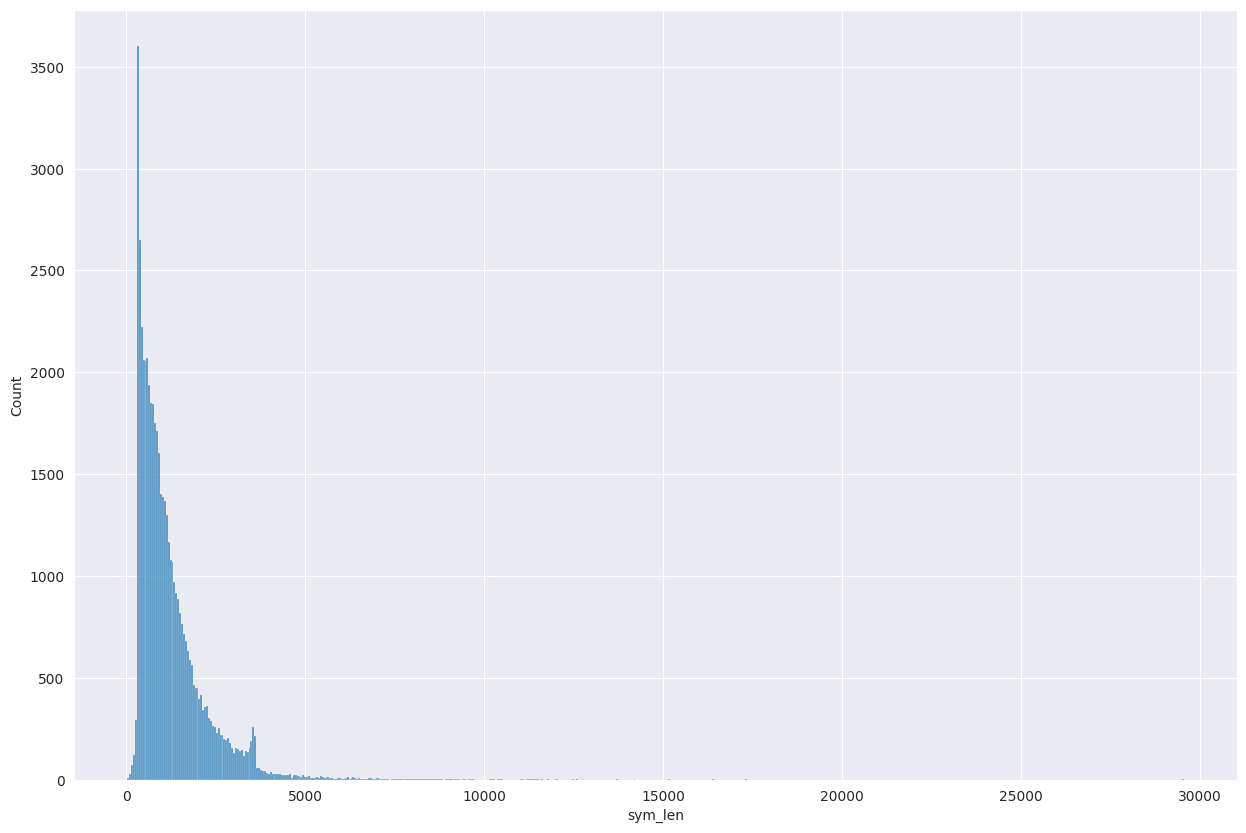

In [17]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df.sym_len)
plt.show()

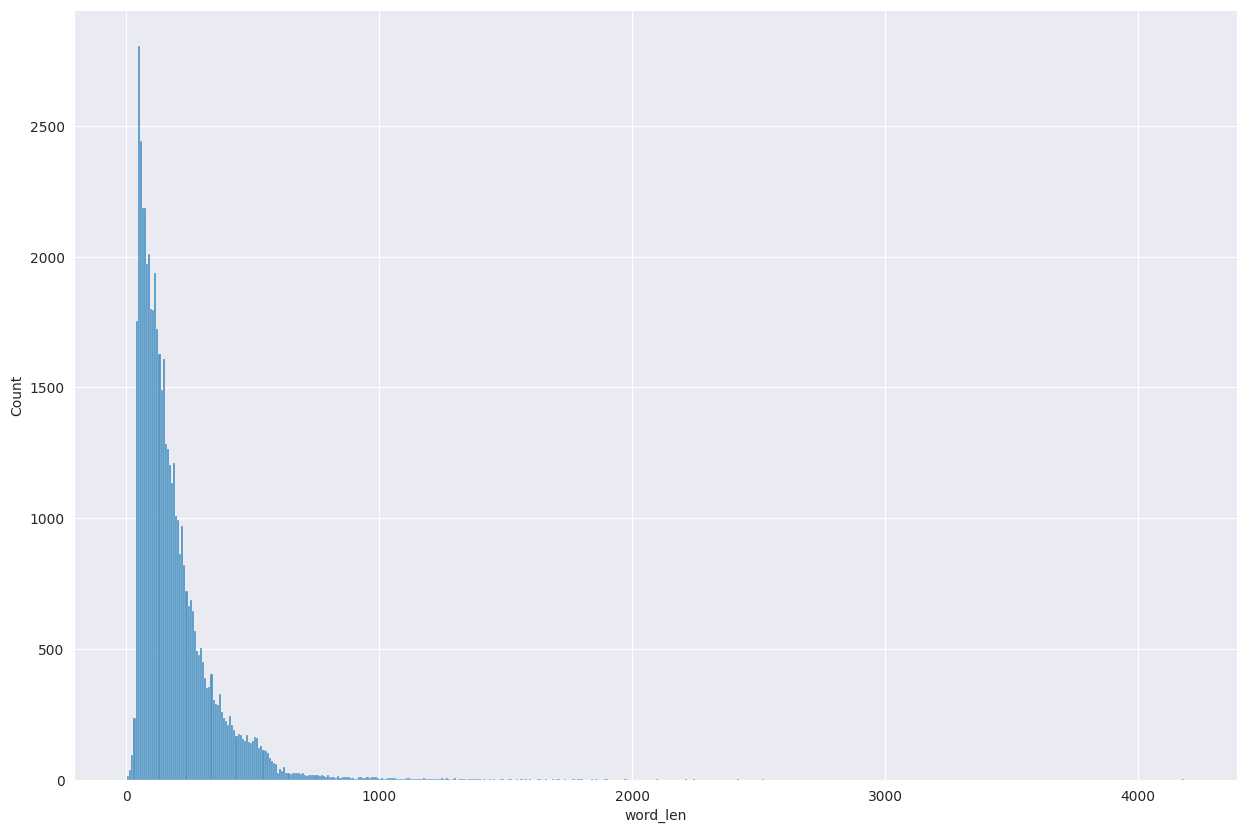

In [18]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df.word_len)
plt.show()

Обратите внимание, у распределений очень длинные хвосты

# Baseline (tf-idf + logreg)

Подготавливаем тексты отзывов (взято из ноутбука второго занятия 😃)

In [20]:
m = MorphAnalyzer()
regex = re.compile("[А-Яа-яA-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]


mystopwords = stopwords.words('russian')
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)

    return ' '.join(remove_stopwords(lemmas))

In [21]:
with Pool(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, df['feeds']), total=len(df)))

df['lemmas'] = lemmas
df.sample(5)

100%|██████████| 51476/51476 [07:42<00:00, 111.23it/s]


,bank,feeds,grades,date,sym_len,word_len,lemmas
44176,promsvyazbank,18 ноября 2020 года заказал кредитную карту. К...,1,2020-11-23 10:11:00,465,76,ноябрь заказать кредитный карта клиент банк яв...
63358,qiwibank,Оформил карту Рокетбанка по рекомендации для о...,1,2018-10-02 23:36:00,1340,208,оформить карта рокетбанка рекомендация ознаком...
66103,bcs-bank,"Зашел в банк поменять валюту, девушка на входе...",1,2019-02-08 20:48:00,343,61,зайти банк поменять валюта девушка вход спроси...
60500,rncb,11 ноября 20 года был оформлен возврат денеж...,1,2021-01-18 12:56:00,328,49,ноябрь оформить возврат денежный средство прой...
68425,qiwibank,"Такая же ситуация, как я смотрю и у всех! Урез...",1,2020-05-11 17:05:00,348,59,ситуация смотреть весь урезать карантин лимит ...


In [22]:
df.to_csv("lemmas.csv")

Будем обучаться исключительно на текстах отзывов (признаки `bank`и `date` не используем от слова совсем -- **мы не используем, а вы в своих решениях попробуйте**)

In [23]:
y_train = df.grades
y_train = y_train.reset_index().drop(columns='index')
#del df # высвободим оперативу, она нам не помешает

In [58]:
df_p = df[df['feeds'].str.contains("\)\)")]
display(df_p.shape[0])
display(df_p['grades'].value_counts())

1120

1    497
5    448
2     93
4     43
3     39
Name: grades, dtype: int64

In [60]:
df_p = df[df['feeds'].str.contains("\(")]
display(df_p.shape[0])
display(df_p['grades'].value_counts())

24766

1    15210
5     4208
2     3309
3     1324
4      715
Name: grades, dtype: int64

In [61]:
df_p = df[df['feeds'].str.contains("не|Не")]
display(df_p.shape[0])
display(df_p['grades'].value_counts())

50338

1    27630
5    13243
2     5614
3     2346
4     1505
Name: grades, dtype: int64

In [207]:
df_p = df[df['feeds'].str.contains('наконец')]
display(df_p.shape[0])
display(df_p['grades'].value_counts())
df_p

1354

1    879
2    216
5    151
3     74
4     34
Name: grades, dtype: int64

,bank,feeds,grades,date,sym_len,word_len,lemmas
38,vtb,Добрый день!Так как нипосещение в в.у. отделен...,2,2020-07-16 07:52:00,1318,197,добрый день нипосещение отделение обращение го...
86,promsvyazbank,Я В-ва Ирина являюсь клиентом банка уже порядк...,1,2019-11-14 16:53:00,1425,222,ирина являться клиент банк порядок обслуживать...
113,citibank,Любой процесс на кошмарном уровне бюрократизир...,2,2019-12-07 15:10:00,2830,442,любой процесс кошмарный уровень бюрократизиров...
140,sberbank,"С.И. Ожегов, Н.Ю. Шведова Толковый словарь рус...",1,2017-01-06 00:02:00,4053,602,ожег шведов толковый словарь русский язык идио...
163,fk_otkritie,Здравствуйте. Уже 5-й день не отображаются коп...,1,2019-11-15 08:35:00,634,94,здравствуйте день отображаться копилка интерне...
...,...,...,...,...,...,...,...
74670,crediteuropebank,В данном банке оформлен кредит 00346-IK-000000...,1,2020-05-12 12:32:00,1838,256,данный банк оформить кредит обратиться колл це...
74711,sberbank,"2 октября писал первый свой отзыв ""Прошел меся...",1,2011-11-02 12:46:00,1968,299,октябрь писать первый свой отзыв пройти месяц ...
74774,homecreditbank,"Оформила карту рассрочки ""Свобода"" в хоуме, не...",2,2018-12-05 11:39:00,1631,223,оформить карта рассрочка свобода хоум некомпет...
74826,homecreditbank,Отзыв о банке Хоум Кредит могу оставить только...,1,2017-01-16 10:10:00,6929,1122,отзыв банк хоум кредит мочь оставить отрицател...


In [150]:
df['grades'].value_counts()

1    27739
5    14227
2     5634
3     2356
4     1520
Name: grades, dtype: int64

Обучимся на всех объектах, а потом сделаем предсказание на тесте из соревнования. Ни больше, ни меньше

In [208]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 2)) # используем уни-, биграммы
bow = vec.fit_transform(lemmas)
clf = LogisticRegression(random_state=42, max_iter=500, warm_start=True)

CPU times: user 20.1 s, sys: 682 ms, total: 20.8 s
Wall time: 20.8 s


In [210]:
y_train[:5]

,grades
0,1
1,2
2,2
3,5
4,2


In [233]:
from sklearn.feature_extraction.text import CountVectorizer
vc_counter = CountVectorizer(ngram_range=(1, 1))
vc_count = vc_counter.fit_transform(df['lemmas'])

vc_frequence = pd.DataFrame(
  # получаем словарь из CountVectorizer
	# c помощью .get_feature_names_out()
  {'word' : vc_counter.get_feature_names_out(),
  # получаем частотность слов
	# находя сумму компонент векторов
  'frequency' : np.array(vc_count.sum(axis = 0))[0]
    }).sort_values(by = 'frequency', ascending = False)

vc_frequence.reset_index(drop=True, inplace=True)
vc_frequence.head(20)

,word,frequency
6900,банк,189653
21354,карта,90697
14485,день,48599
23558,кредит,47845
50471,сотрудник,46579
23329,который,40967
14490,деньга,39456
21921,клиент,37730
34717,отделение,36037
27272,мочь,33215


In [248]:
gen_negtopos = round(df[df["grades"] < 3].value_counts().sum() / df[df["grades"] > 3].value_counts().sum(), 2)

def get_emotion(word , freq):
    df_p = df[df['lemmas'].str.contains(word)]
    print(f'Word: {word}. Docs count: {df_p.shape[0]}, freq: {freq}')
    negtopos = round(df_p[df_p["grades"] < 3].value_counts().sum() / df_p[df_p["grades"] > 3].value_counts().sum(), 2)
    print(f'Neg/Pos: {negtopos}. GEN: {gen_negtopos}')
    if negtopos > 1.5*gen_negtopos:
        print('---')
    elif negtopos < gen_negtopos/1.5:
        print('+++')
    else:
        print('000')

In [246]:
get_emotion(vc_frequence.at[0, 'word'].iloc[0], vc_frequence.at[0, 'frequency'])

Word: банк. Docs count: 47840, freq: 189653
Neg/Pos: 2.23. GEN: 2.12
000


In [249]:
for i in range(30):
    get_emotion(vc_frequence.at[i, 'word'].iloc[0], vc_frequence.at[i, 'frequency'])

Word: банк. Docs count: 47840, freq: 189653
Neg/Pos: 2.23. GEN: 2.12
000
Word: карта. Docs count: 24277, freq: 90697
Neg/Pos: 2.42. GEN: 2.12
000
Word: день. Docs count: 31995, freq: 48599
Neg/Pos: 3.36. GEN: 2.12
---
Word: кредит. Docs count: 25045, freq: 47845
Neg/Pos: 2.56. GEN: 2.12
000
Word: сотрудник. Docs count: 22241, freq: 46579
Neg/Pos: 1.87. GEN: 2.12
000
Word: который. Docs count: 23461, freq: 40967
Neg/Pos: 3.06. GEN: 2.12
000
Word: деньга. Docs count: 17420, freq: 39456
Neg/Pos: 3.92. GEN: 2.12
---
Word: клиент. Docs count: 22123, freq: 37730
Neg/Pos: 2.19. GEN: 2.12
000
Word: отделение. Docs count: 16856, freq: 36037
Neg/Pos: 2.67. GEN: 2.12
000
Word: мочь. Docs count: 24877, freq: 33215
Neg/Pos: 2.91. GEN: 2.12
000
Word: свой. Docs count: 19054, freq: 30514
Neg/Pos: 2.56. GEN: 2.12
000
Word: вопрос. Docs count: 18768, freq: 30423
Neg/Pos: 1.92. GEN: 2.12
000
Word: счёт. Docs count: 14240, freq: 30421
Neg/Pos: 3.82. GEN: 2.12
---
Word: сказать. Docs count: 19457, freq: 2

In [251]:
from collections import Counter
df['lemma_count'] = df['lemmas'].str.split().apply(lambda x: Counter(x))
df['lemma_count'].head(20)

0     {'являться': 1, 'клиент': 5, 'банк': 4, 'после...
1     {'ростов': 1, 'ленин': 1, 'данный': 3, 'офис':...
4     {'иметь': 1, 'потребительский': 1, 'кредит': 2...
7     {'хотеть': 1, 'выразить': 1, 'глубокий': 1, 'б...
8     {'март': 3, 'проход': 1, 'метро': 3, 'курский'...
11    {'познакомиться': 1, 'конец': 1, 'практически'...
12    {'офис': 1, 'совкомбанк': 1, 'снимать': 1, 'со...
14    {'добрый': 1, 'день': 1, 'терять': 1, 'клиент'...
15    {'добрый': 1, 'день': 2, 'хотеть': 1, 'обратит...
16    {'август': 1, 'откликнуться': 1, 'предложение'...
17    {'зайти': 1, 'альфа': 1, 'клик': 1, 'обнаружит...
18    {'март': 2, 'магнит': 2, 'расплатиться': 1, 'к...
19    {'день': 1, 'обратиться': 1, 'офис': 1, 'банк'...
21    {'здравствуйте': 1, 'иметь': 1, 'обязательство...
22    {'ценить': 1, 'сотрудничество': 1, 'банк': 4, ...
23    {'здравствуйте': 1, 'являться': 2, 'клиент': 2...
24    {'примерно': 1, 'приложение': 1, 'возникнуть':...
26    {'решить': 1, 'перевести': 1, 'свой': 2, '

In [ ]:
for i in range(30):
    get_emotion(vc_frequence.at[i, 'word'].iloc[0], vc_frequence.at[i, 'frequency'])


In [ ]:
# небольшой трюк: будем обучаться частями
ran = np.arange(y_train.shape[0])
inds = np.array_split(ran, 10) # разобъем на 10 частей
# и подмешаем к каждому куску случайных объектов
inds = [np.concatenate((chunk, np.array(random.sample(list(ran), k=1000))), axis=None) for chunk in inds]

for chunk in tqdm(inds):
    clf.fit(bow[chunk, :], y_train.iloc[chunk])

Загрузим тест. Предобработаем отзывы в нем и сделаем предсказания

In [ ]:
test = pd.read_csv('test_ml.csv', index_col=0)
test

In [26]:
with Pool(4) as p:
    lemmas_test = list(tqdm(p.imap(clean_text, test['feeds']), total=len(test)))


100%|██████████| 17220/17220 [02:23<00:00, 119.86it/s]


In [27]:
test['lemmas'] = lemmas_test
df.to_csv("lemmas_test.csv")

In [ ]:
#zero short learning ???

In [ ]:
pred = clf.predict(vec.transform(lemmas_test))
pred

In [ ]:
sol = pd.DataFrame({'inds': test.index, 'grades': pred})
sol

In [ ]:
sol.to_csv('result.csv', index=False)

Кстати, если обратите внимание на содержимое вектора предсказанных классов, то наверняка заметите, что модель предсказывает только 1 и 5 и вообще никогда 2, 3 и 4. Отчасти это логично -- наблюдается сильный дисбаланс классов. Но этот недочет неплохо бы исправить в ваших решениях

In [ ]:
unique, counts = np.unique(pred, return_counts=True)
np.asarray((unique, counts)).T